# SVM For each continent and religion

In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as smrp
import sklearn as sk
import country_converter as coco
import pycountry

In [170]:
dichotomous_df = pd.read_csv('../datasets/processed/democracy/dichotomous/dichotomous-democracy-snapshot.csv', header=0)
world_bank_df = pd.read_csv('../datasets/processed/women/world-bank/women-business-and-the-law-snapshot.csv', header=0)
religious_diversity_df = pd.read_csv('../datasets/processed/religion/pew-research-center-religion-diversity/religious-diversity-index-extended.csv', header=0)

merged_df = dichotomous_df.merge(world_bank_df, on='iso3', how='inner', suffixes=('_f', '_g'))
merged_df = merged_df.merge(religious_diversity_df, on='iso3', how='inner', suffixes=('_f', '_g'))

print(f"Countries in Dichotomous Democracy: {len(dichotomous_df)}")
print(f"Countries in World Bank: {len(world_bank_df)}")
print(f"Countries in Religious Diversity: {len(religious_diversity_df)}")
print(f"Countries in all the datasets: {len(merged_df)}")
merged_df.head()

Countries in Dichotomous Democracy: 191
Countries in World Bank: 190
Countries in Religious Diversity: 230
Countries in all the datasets: 183


,iso3,country_f,ccode,abbreviation,abbreviation_undp,democracy,democracy_trans,democracy_breakdowns,democracy_duration,democracy_omitteddata,democracy_femalesuffrage,country_g,ISO Code,wbl_index,mobility,woman_choose_residence,woman_travel_outside_home,woman_apply_passport,woman_travel_abroad,workplace,woman_get_job,law_prohibits_gender_discrimination,law_sexual_harassment,penalties_sexual_harassment,pay,law_equal_pay,woman_work_night,woman_work_dangerous,woman_work_industrial,marriage,no_obey_husband_law,woman_head_household,law_domestic_violence,woman_divorce_rights,woman_remarry_rights,parenthood,paid_maternity_leave_14weeks,paid_maternity_leave_length,govt_pays_maternity_leave,paid_paternity_leave,paid_paternity_leave_length,paid_parental_leave,parental_leave_shared_days,parental_leave_mother_days,parental_leave_father_days,protect_pregnant_workers,entrepreneurship,law_credit_gender_discrimination,woman_sign_contract,woman_register_business,woman_open_bank_account,assets,equal_property_rights,equal_inheritance_children,equal_inheritance_spouses,equal_asset_admin_marriage,value_nonmonetary_contributions,pension,equal_pension_age_full,equal_pension_age_partial,equal_retirement_age,pension_credit_childcare,country,rdi,christian,muslim,unaffiliated,hindu,buddhist,folk,other,jewish,population,dominant_religion,maj_christian,maj_muslim,maj_unaffiliated,maj_hindu,maj_buddhist,maj_folk,maj_other,maj_jewish
0,USA,UNITED STATES OF AMERICA,2,USA,USA,1.0,0,0,206,1,1,United States,USA,91.25,100,True,True,True,True,100,True,True,True,True,75,False,True,True,True,100,True,True,True,True,True,80,False,0,True,True,0,True,0,84,84,True,100,True,True,True,True,100,True,True,True,True,True,75,True,True,True,False,United States,4.1,0.783,0.009,0.164,0.006,0.012,0.002,0.006,0.018,310380000,christian,1,0,0,0,0,0,0,0
1,CAN,CANADA,20,CAN,CAN,1.0,0,0,139,1,1,Canada,CAN,100.00,100,True,True,True,True,100,True,True,True,True,100,True,True,True,True,100,True,True,True,True,True,100,True,105,True,True,0,True,210,35,35,True,100,True,True,True,True,100,True,True,True,True,True,100,True,True,True,True,Canada,5.3,0.690,0.021,0.237,0.014,0.008,0.012,0.009,0.010,34020000,christian,1,0,0,0,0,0,0,0
2,BHS,BAHAMAS,31,BHS,BHS,1.0,0,0,33,1,1,"Bahamas, The",BHS,81.25,100,True,True,True,True,100,True,True,True,True,75,False,True,True,True,80,True,True,True,False,True,20,False,84,False,False,0,False,0,0,0,True,75,False,True,True,True,100,True,True,True,True,True,100,True,True,True,True,Bahamas,0.9,0.960,0.001,0.031,0.000,0.000,0.003,0.003,0.000,340000,christian,1,0,0,0,0,0,0,0
3,HTI,HAITI,41,HTI,HAI,0.0,0,0,186,0,0,Haiti,HTI,61.25,50,False,True,False,True,50,True,True,False,False,100,True,True,True,True,40,True,True,False,False,False,40,False,84,True,False,0,False,0,0,0,True,75,False,True,True,True,60,False,True,True,False,True,75,True,True,True,False,Haiti,2.7,0.869,0.000,0.106,0.000,0.000,0.022,0.003,0.000,9990000,christian,1,0,0,0,0,0,0,0
4,DOM,DOMINICAN REPUBLIC,42,DOM,DOM,1.0,0,0,40,1,1,Dominican Republic,DOM,86.25,100,True,True,True,True,100,True,True,True,True,75,False,True,True,True,80,True,True,True,False,True,60,True,98,False,True,2,False,0,0,0,True,100,True,True,True,True,100,True,True,True,True,True,75,True,True,True,False,Dominican Republic,2.4,0.880,0.000,0.109,0.000,0.000,0.009,0.001,0.000,9930000,christian,1,0,0,0,0,0,0,0


In [171]:
merged_df['continent'] = coco.convert(merged_df['iso3'], to='continent')
predictors = ["continent", "iso3", "democracy", "wbl_index", "mobility", "workplace", "pay", "marriage", "parenthood", "entrepreneurship", "assets", "pension"]
reduced_df = merged_df[predictors]
reduced_df['dominant_religion'] = merged_df['dominant_religion'].apply(lambda x: 'christian' if x == 'christian' else 'muslim' if x == 'muslim' else 'other')

for continent in reduced_df['continent'].unique():
    for religion in reduced_df['dominant_religion'].unique():
        print(f"Continent: {continent}, Religion: {religion}")


Continent: America, Religion: christian
Continent: America, Religion: other
Continent: America, Religion: muslim
Continent: Europe, Religion: christian
Continent: Europe, Religion: other
Continent: Europe, Religion: muslim
Continent: Asia, Religion: christian
Continent: Asia, Religion: other
Continent: Asia, Religion: muslim
Continent: Africa, Religion: christian
Continent: Africa, Religion: other
Continent: Africa, Religion: muslim
Continent: Oceania, Religion: christian
Continent: Oceania, Religion: other
Continent: Oceania, Religion: muslim


/var/folders/3c/bf3091xd4h9fj5rvqhp6_05r0000gq/T/ipykernel_16000/3666470496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['dominant_religion'] = merged_df['dominant_religion'].apply(lambda x: 'christian' if x == 'christian' else 'muslim' if x == 'muslim' else 'other')


No data for other - America
Combination other - Europe has only one class: [1.]
47    CZE
63    EST
Name: iso3, dtype: object
Combination other - Africa has only one class: [1.]
121    MUS
Name: iso3, dtype: object
No data for other - Oceania
No data for muslim - America
Combination muslim - Europe has only one class: [1.]
52    ALB
Name: iso3, dtype: object
No data for muslim - Oceania


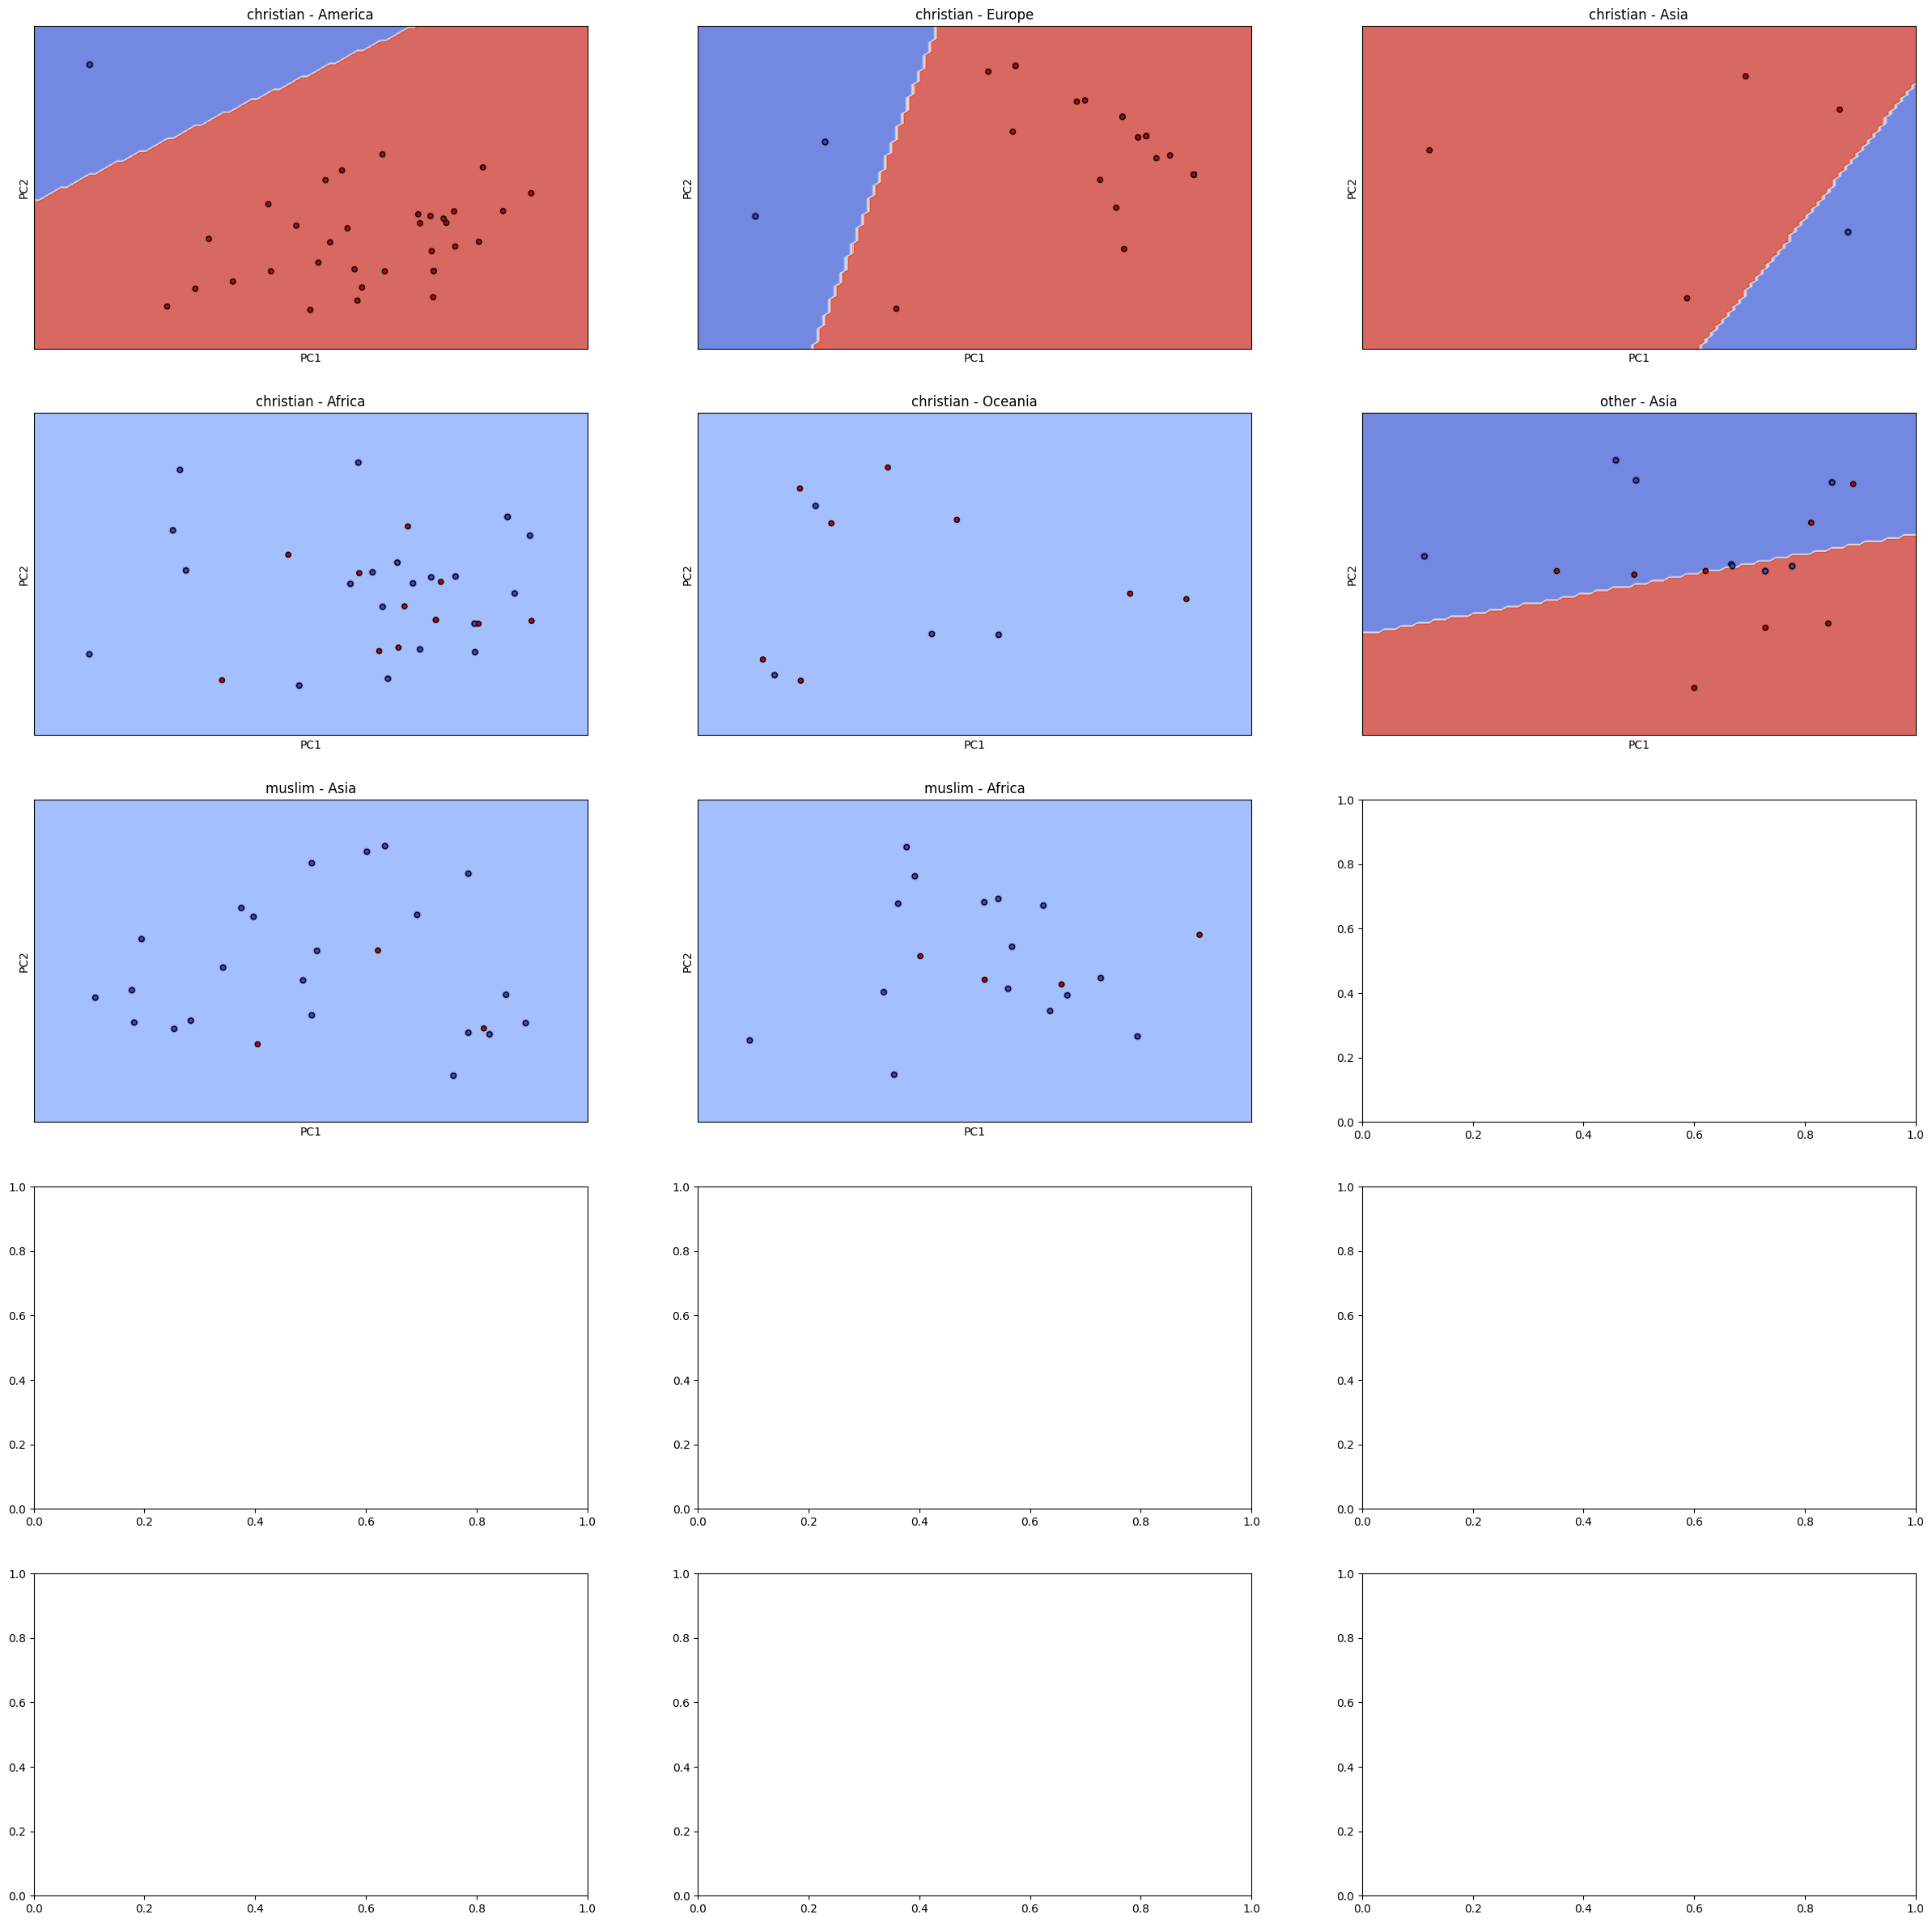

In [172]:
fig, ax = plt.subplots(5, 3, figsize=(30, 30))

ax = ax.flatten()

i = -1
for religion in reduced_df['dominant_religion'].unique():
    for continent in reduced_df['continent'].unique():
        X_cont_relig = reduced_df[(reduced_df['continent'] == continent) & (reduced_df['dominant_religion'] == religion)]
        y_cont_relig = X_cont_relig['democracy']
        X_cont_relig_numeric = X_cont_relig.drop(columns=["continent", "dominant_religion","iso3","democracy"])
        if len(X_cont_relig) > 0:
            if len(y_cont_relig.unique()) > 1:
                i += 1
                scaler = sk.preprocessing.StandardScaler()
                X_cont_relig_scaled = scaler.fit_transform(X_cont_relig_numeric)
                pca = sk.decomposition.PCA(n_components=2)
                X_cont_relig_pca = pca.fit_transform(X_cont_relig_scaled)
                ax[i].scatter(X_cont_relig_pca[:, 0], X_cont_relig_pca[:, 1], c=y_cont_relig, cmap='viridis')
                ax[i].set_title(f"{religion} - {continent}")
                ax[i].set_xlabel('PC1')
                ax[i].set_ylabel('PC2')
                C = 10.0
                model = sk.svm.SVC(kernel="linear", C=C)
                model = model.fit(X_cont_relig_pca, y_cont_relig)
                disp = sk.inspection.DecisionBoundaryDisplay.from_estimator(
                    model,
                    X_cont_relig_pca,
                    response_method="predict",
                    cmap=plt.cm.coolwarm,
                    alpha=0.8,
                    ax=ax[i],
                    xlabel="PCA1",
                    ylabel="PCA2",
                )
                ax[i].scatter(X_cont_relig_pca[:, 0], X_cont_relig_pca[:, 1], c=y_cont_relig, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
                ax[i].set_xticks(())
                ax[i].set_yticks(())
            else:
                print(f"Combination {religion} - {continent} has only one class: {y_cont_relig.unique()}")
                print(X_cont_relig["iso3"])
        else:
            print(f"No data for {religion} - {continent}")

I'll study four cases
- America, Europe, Asia (Excluding Africa and Oceania)
- Muslim majority
- Africa
- Oceania

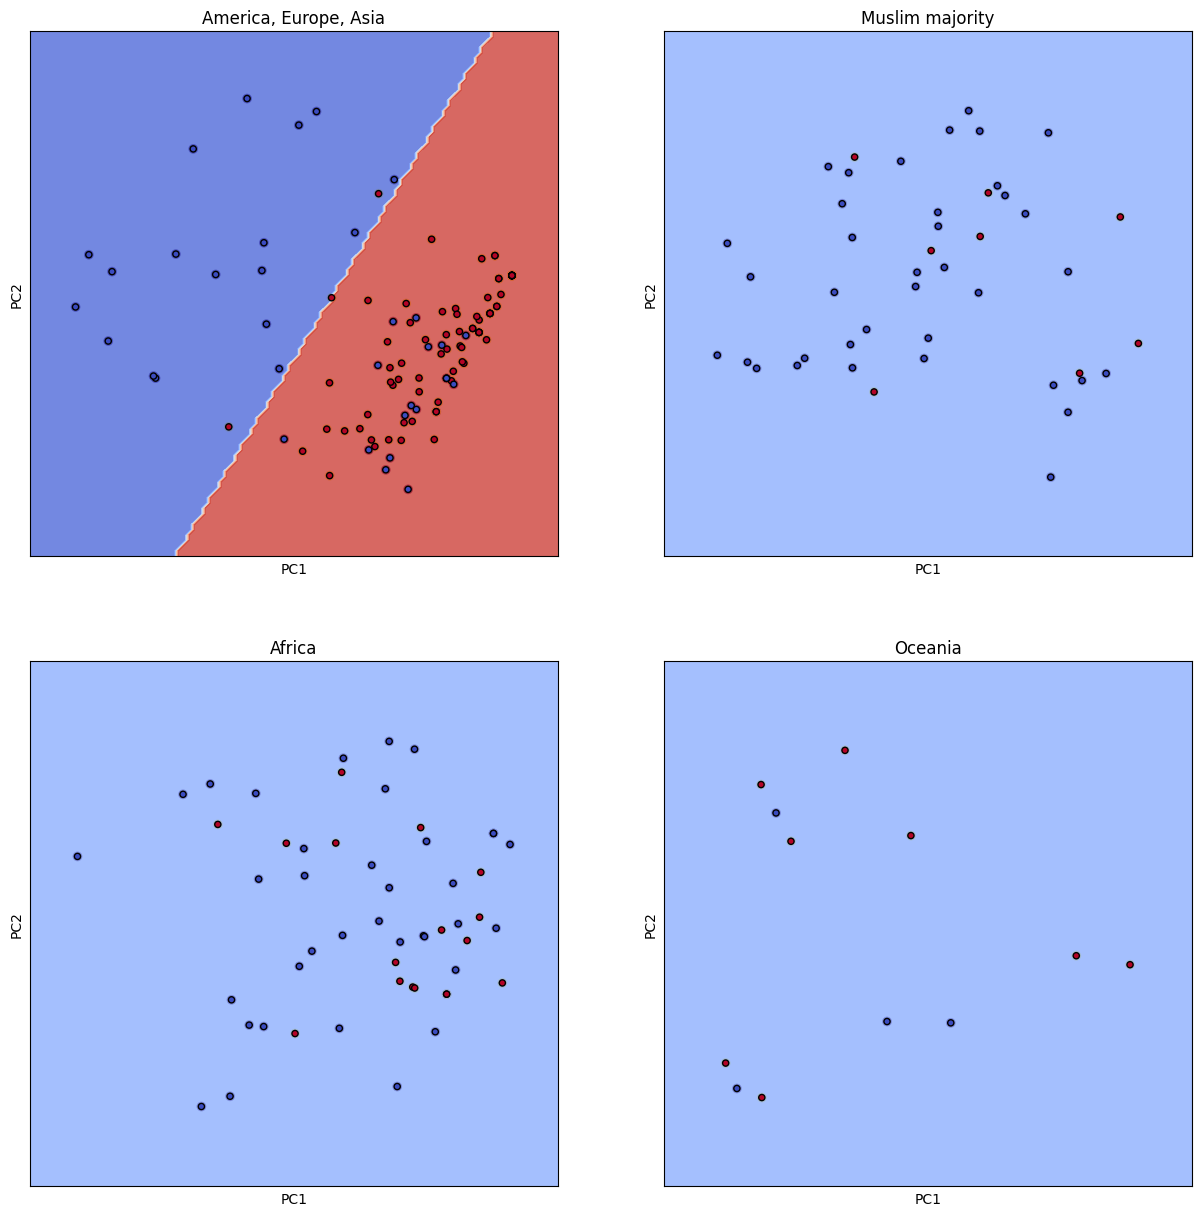

In [173]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax = ax.flatten()

cases = [
    (reduced_df[(reduced_df['continent'] == 'America') | (reduced_df['continent'] == 'Europe') | (reduced_df['continent'] == 'Asia')], 'America, Europe, Asia'),
    (reduced_df[(reduced_df['dominant_religion'] == 'muslim')], 'Muslim majority'),
    (reduced_df[(reduced_df['continent'] == 'Africa')], 'Africa'),
    (reduced_df[(reduced_df['continent'] == 'Oceania')], 'Oceania'),
]

i = -1
for case in cases:
    X_cont_relig = case[0]
    label = case[1]
    y_cont_relig = X_cont_relig['democracy']
    X_cont_relig_numeric = X_cont_relig.drop(columns=["continent", "dominant_religion","iso3","democracy"])
    if len(X_cont_relig) > 0:
        if len(y_cont_relig.unique()) > 1:
            i += 1
            scaler = sk.preprocessing.StandardScaler()
            X_cont_relig_scaled = scaler.fit_transform(X_cont_relig_numeric)
            pca = sk.decomposition.PCA(n_components=2)
            X_cont_relig_pca = pca.fit_transform(X_cont_relig_scaled)
            ax[i].scatter(X_cont_relig_pca[:, 0], X_cont_relig_pca[:, 1], c=y_cont_relig, cmap='viridis')
            ax[i].set_title(f"{label}")
            ax[i].set_xlabel('PC1')
            ax[i].set_ylabel('PC2')
            C = 10.0
            model = sk.svm.SVC(kernel="linear", C=C)
            model = model.fit(X_cont_relig_pca, y_cont_relig)
            disp = sk.inspection.DecisionBoundaryDisplay.from_estimator(
                model,
                X_cont_relig_pca,
                response_method="predict",
                cmap=plt.cm.coolwarm,
                alpha=0.8,
                ax=ax[i],
                xlabel="PCA1",
                ylabel="PCA2",
            )
            ax[i].scatter(X_cont_relig_pca[:, 0], X_cont_relig_pca[:, 1], c=y_cont_relig, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
            ax[i].set_xticks(())
            ax[i].set_yticks(())
        else:
            print(f"Case {label} has only one class: {y_cont_relig.unique()}")
            print(X_cont_relig["iso3"])
    else:
        print(f"No data for {label}")

It seems there is a clear separation in America, Europe, and Asia

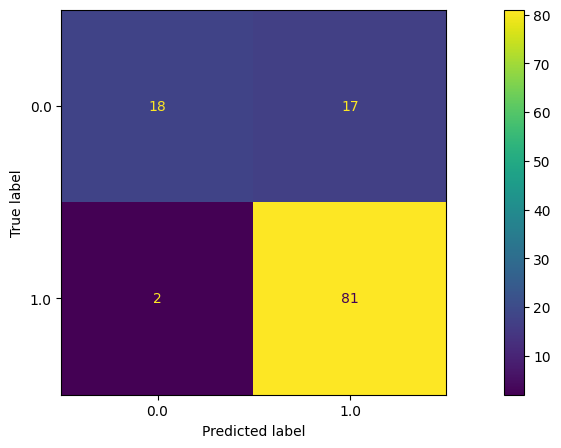

In [174]:

def conf_matrix(countries_dataset):
    y = countries_dataset['democracy']
    X = countries_dataset.drop(columns=["continent", "dominant_religion","iso3","democracy"])
    scaler = sk.preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = sk.decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    model = sk.svm.SVC(kernel="linear", C=C)
    model = model.fit(X_pca, y)
    y_pred = model.predict(X_pca)


    fig, sub = plt.subplots(1, 1, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    ax = sub

    cm = sk.metrics.confusion_matrix(y, y_pred)
    disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

amer_eu_asia = reduced_df[(reduced_df['continent'] == 'America') | (reduced_df['continent'] == 'Europe') | (reduced_df['continent'] == 'Asia')]
conf_matrix(amer_eu_asia)

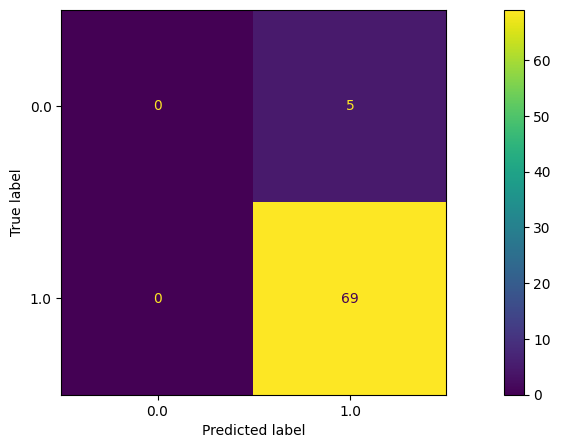

In [175]:
amer_eu_asia = reduced_df[(reduced_df['continent'] == 'America') | (reduced_df['continent'] == 'Europe') | (reduced_df['continent'] == 'Asia')]
amer_eu_asia = amer_eu_asia[(amer_eu_asia['dominant_religion'] == 'christian')]
conf_matrix(amer_eu_asia)

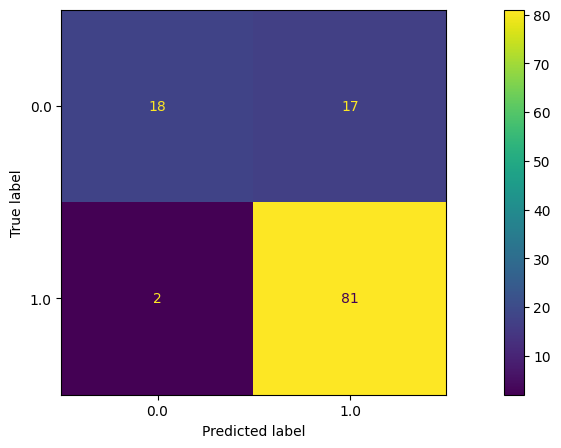

In [176]:
amer_eu_asia = reduced_df[(reduced_df['continent'] == 'America') | (reduced_df['continent'] == 'Europe') | (reduced_df['continent'] == 'Asia')]
# amer_eu_asia = amer_eu_asia[amer_eu_asia['dominant_religion'] != 'muslim']
conf_matrix(amer_eu_asia)

In [177]:
freedom_world_df = pd.read_csv('../datasets/processed/democracy/freedom-world/freedom-world-snapshot.csv', header=0)
world_bank_df = pd.read_csv('../datasets/processed/women/world-bank/women-business-and-the-law-snapshot.csv', header=0)
religious_diversity_df = pd.read_csv('../datasets/processed/religion/pew-research-center-religion-diversity/religious-diversity-index-extended.csv', header=0)

merged_df = freedom_world_df.merge(world_bank_df, on='iso3', how='inner', suffixes=('_f', '_g'))
merged_df = merged_df.merge(religious_diversity_df, on='iso3', how='inner', suffixes=('_f', '_g'))

merged_df['continent'] = coco.convert(merged_df['iso3'], to='continent')

In [178]:
amer_eu_asia = merged_df[(merged_df['continent'] == 'America') | (merged_df['continent'] == 'Europe') | (merged_df['continent'] == 'Asia')]
print(len(amer_eu_asia))
predictors = ["total","wbl_index","mobility","workplace","pay","marriage","parenthood","entrepreneurship","assets","pension","rdi", "maj_christian","maj_muslim","maj_unaffiliated","maj_hindu","maj_buddhist","maj_folk","maj_other","maj_jewish"]
X = amer_eu_asia[predictors]

scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
# Recover the original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled = sm.add_constant(X_scaled)

results_reg = smf.ols(formula='total ~ wbl_index + mobility + workplace + pay + marriage + parenthood + entrepreneurship + assets + pension + rdi', data=X_scaled).fit()
print(results_reg.summary())

121
                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     12.40
Date:                Thu, 08 May 2025   Prob (F-statistic):           2.03e-13
Time:                        11:29:43   Log-Likelihood:                -129.60
No. Observations:                 121   AIC:                             279.2
Df Residuals:                     111   BIC:                             307.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6.939e-18      0.0

In [183]:
predictors = ["total","wbl_index","mobility","workplace","pay","marriage","parenthood","entrepreneurship","assets","pension"]
amer_eu_asia = merged_df[(merged_df['continent'] == 'America') | (merged_df['continent'] == 'Europe') | (merged_df['continent'] == 'Asia')]
X = amer_eu_asia[predictors]
y_lasso = X["total"]
X_lasso = X.drop(columns=["total"])
scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X_lasso)
poly = sk.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
poly_feature_names = poly.get_feature_names_out(X_lasso.columns)

lasso = sk.linear_model.Lasso(alpha=0.1)
lasso.fit(X_poly, y_lasso)

results_df = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': lasso.coef_
})

y_pred = lasso.predict(X_poly)
r2 = sk.metrics.r2_score(y_lasso, y_pred)

print("Lasso Regression Results:")
print(f"Intercept: {lasso.intercept_}")
print(f"R-squared: {r2}")
# Set display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(results_df.sort_values('Coefficient', ascending=False))

Lasso Regression Results:
Intercept: 64.79279892053889
R-squared: 0.7817949823274322
                        Feature  Coefficient
5                    parenthood    13.440861
8                       pension    11.380782
2                     workplace    10.080133
34                 pay marriage     9.380343
52               assets pension     8.476313
29         workplace parenthood     5.982618
35               pay parenthood     5.642619
44                 parenthood^2     4.597807
45  parenthood entrepreneurship     3.577100
31             workplace assets     3.308291
18                   mobility^2     2.834885
30   workplace entrepreneurship     1.916127
25             mobility pension     1.408832
48           entrepreneurship^2     1.221774
3                           pay     1.120378
22          mobility parenthood     0.991286
19           mobility workplace     0.744094
53                    pension^2     0.204522
17            wbl_index pension    -0.000000
4              

In [180]:
predictors = ["total","wbl_index","mobility","workplace","pay","marriage","parenthood","entrepreneurship","assets","pension","rdi"]
africa = merged_df[(merged_df['continent'] == 'Africa')]
print(len(africa))
X = africa[predictors]
y_lasso = X["total"]
X_lasso = X.drop(columns=["total"])
scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X_lasso)
poly = sk.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
poly_feature_names = poly.get_feature_names_out(X_lasso.columns)

lasso = sk.linear_model.Lasso(alpha=0.1)
lasso.fit(X_poly, y_lasso)

results_df = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': lasso.coef_
})

y_pred = lasso.predict(X_poly)
r2 = sk.metrics.r2_score(y_lasso, y_pred)

print("Lasso Regression Results:")
print(f"Intercept: {lasso.intercept_}")
print(f"R-squared: {r2}")
# Set display options to show all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(results_df.sort_values('Coefficient', ascending=False))

54
Lasso Regression Results:
Intercept: 54.4731565485838
R-squared: 0.8906139058837379
                        Feature  Coefficient
4                      marriage    26.803516
47              marriage assets    15.429801
26              mobility assets    12.965397
43                      pay rdi    12.174530
52            parenthood assets    11.685127
6              entrepreneurship    11.339036
57     entrepreneurship pension    11.170620
5                    parenthood    10.892064
31           workplace marriage     6.989986
28                 mobility rdi     6.713962
48             marriage pension     6.240932
33   workplace entrepreneurship     5.603799
30                workplace pay     5.454619
61                   assets rdi     4.009046
41                   pay assets     3.011970
3                           pay     2.916174
36                workplace rdi     1.493575
46    marriage entrepreneurship     1.443565
63                  pension rdi     1.029463
9            

/Users/damian.calabresi/Studies/UMD/MSML 602 - Principles of Data Science/project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.553e+00, tolerance: 3.337e+00
  model = cd_fast.enet_coordinate_descent(


In [186]:
africa_oceania = merged_df[(merged_df['continent'] == 'Africa') | (merged_df['continent'] == 'Oceania')]
X = africa_oceania[predictors]

scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
# Recover the original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled = sm.add_constant(X_scaled)

results_reg = smf.ols(formula='total ~ wbl_index + mobility + workplace + pay + marriage + parenthood + entrepreneurship + assets + pension', data=X_scaled).fit()
print(results_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     9.831
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.84e-08
Time:                        11:54:48   Log-Likelihood:                -65.039
No. Observations:                  66   AIC:                             148.1
Df Residuals:                      57   BIC:                             167.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          1.11e-16      0.086  